In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

import os
import numpy as np

import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')

In [2]:
datasets , info = tfds.load(name = 'beans', with_info = True, as_supervised = True, split = ['train', 'test', 'validation'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incomplete58GL9X/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incomplete58GL9X/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incomplete58GL9X/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir=PosixGPath('/tmp/tmpdn9px7nhtfds'),
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo 

In [4]:
datasets

[<_PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [5]:
train, info_train = tfds.load(name = 'beans', with_info = True, split = 'test')

# tfds.show_examples(info_train, train) # Deprecated

WARNING: For consistency with `tfds.load`, the `tfds.show_examples` signature has been modified from (info, ds) to (ds, info).
The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`

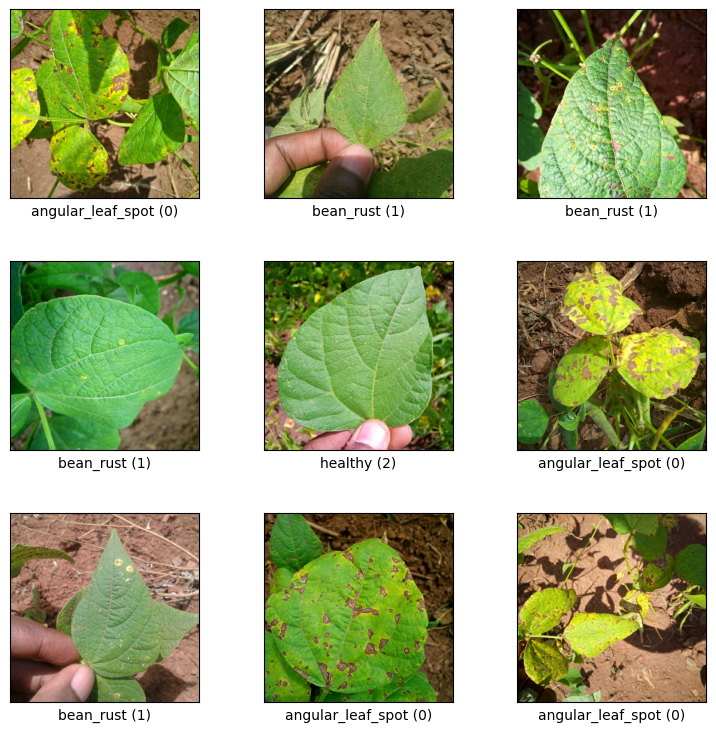

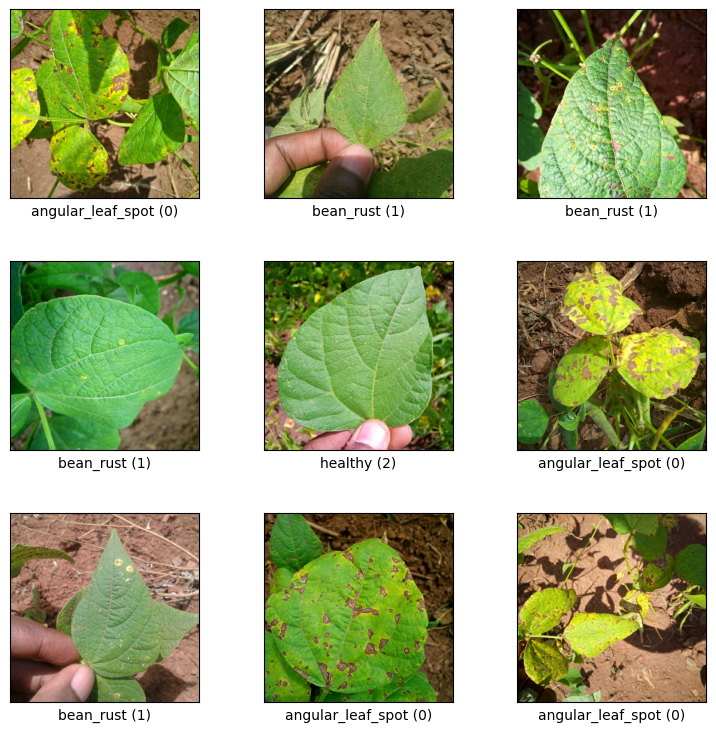

In [6]:
tfds.show_examples(train, info_train)

In [7]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0

    return tf.image.resize(image, [224, 224]), tf.one_hot(label, 3)

In [8]:
def get_dataset(batch_size = 32):
    train_dataset_sclaed = datasets[0].map(scale).shuffle(1000).batch(batch_size)
    test_dataset_sclaed = datasets[1].map(scale).batch(batch_size)
    validation_dataset_sclaed = datasets[2].map(scale).batch(batch_size)

    return train_dataset_sclaed, test_dataset_sclaed, validation_dataset_sclaed


In [9]:
train_dataset, test_dataset, val_dataset = get_dataset()

train_dataset.cache()
val_dataset.cache()

<CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [10]:
len(list(datasets[0]))

1034

In [11]:
feature_extractor = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [12]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape = (224, 224, 3))

In [13]:
feature_extractor_layer.trainable = False

In [14]:
model = tf.keras.Sequential(
    [
        feature_extractor_layer,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(3, activation = 'softmax')
    ]
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [16]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc']
)

In [17]:
history = model.fit(train_dataset, epochs = 6, validation_data = val_dataset)

Epoch 1/6
33/33 [==============================] - 59s 2s/step - loss: 0.8693 - acc: 0.5851 - val_loss: 0.5141 - val_acc: 0.7669
Epoch 2/6
33/33 [==============================] - 52s 2s/step - loss: 0.5342 - acc: 0.7660 - val_loss: 0.4078 - val_acc: 0.8346
Epoch 3/6
33/33 [==============================] - 52s 2s/step - loss: 0.4304 - acc: 0.8346 - val_loss: 0.3497 - val_acc: 0.8496
Epoch 4/6
33/33 [==============================] - 47s 1s/step - loss: 0.3754 - acc: 0.8482 - val_loss: 0.3185 - val_acc: 0.8797
Epoch 5/6
33/33 [==============================] - 48s 1s/step - loss: 0.3313 - acc: 0.8733 - val_loss: 0.2936 - val_acc: 0.8722
Epoch 6/6
33/33 [==============================] - 56s 2s/step - loss: 0.3135 - acc: 0.8743 - val_loss: 0.2751 - val_acc: 0.9248


In [18]:
result = model.evaluate(test_dataset)

4/4 [==============================] - 6s 1s/step - loss: 0.2827 - acc: 0.8750


In [19]:
%matplotlib inline

1/1 [==============================] - 1s 852ms/step
[[0.8661598  0.13281992 0.00102021]]


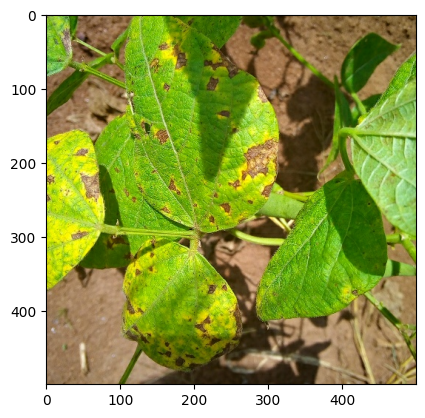

Actual Label : angular_leaf_spot
Predicted Label : angular_leaf_spot
1/1 [==============================] - 0s 59ms/step
[[0.01619844 0.95088696 0.03291453]]


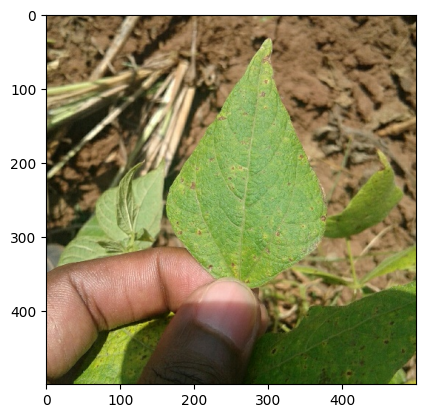

Actual Label : bean_rust
Predicted Label : bean_rust
1/1 [==============================] - 0s 55ms/step
[[0.23868345 0.61968    0.14163652]]


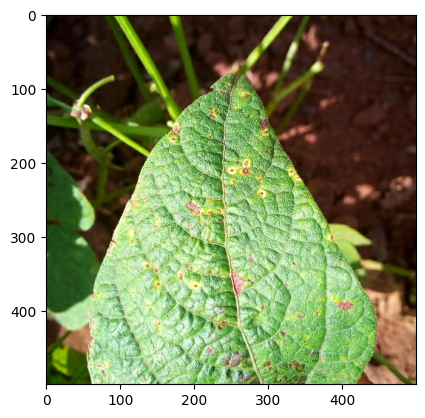

Actual Label : bean_rust
Predicted Label : bean_rust
1/1 [==============================] - 0s 51ms/step
[[0.01639195 0.22682393 0.7567841 ]]


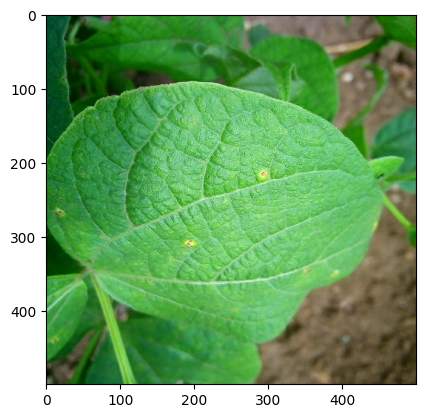

Actual Label : bean_rust
Predicted Label : healthy
1/1 [==============================] - 0s 77ms/step
[[0.00179188 0.00291757 0.9952905 ]]


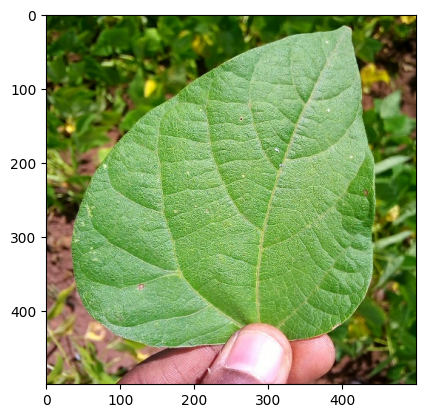

Actual Label : healthy
Predicted Label : healthy
1/1 [==============================] - 0s 62ms/step
[[0.7971011  0.19812188 0.00477704]]


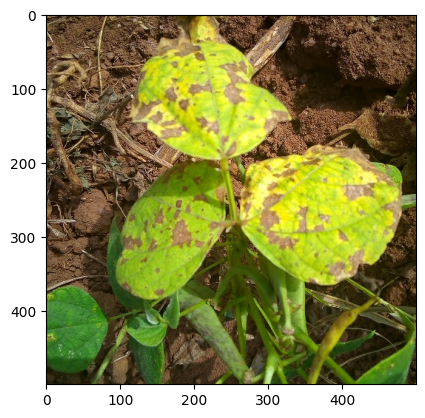

Actual Label : angular_leaf_spot
Predicted Label : angular_leaf_spot
1/1 [==============================] - 0s 64ms/step
[[0.01317246 0.95625454 0.03057294]]


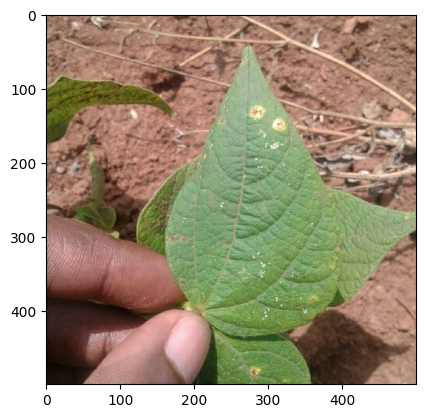

Actual Label : bean_rust
Predicted Label : bean_rust
1/1 [==============================] - 0s 85ms/step
[[0.96008354 0.03542466 0.00449189]]


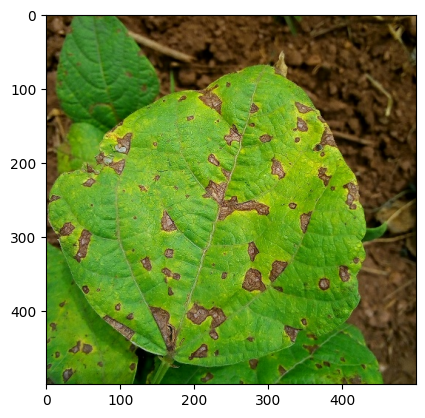

Actual Label : angular_leaf_spot
Predicted Label : angular_leaf_spot
1/1 [==============================] - 0s 62ms/step
[[0.8994761  0.09797047 0.00255334]]


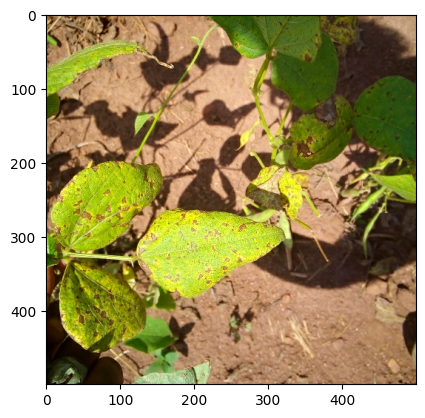

Actual Label : angular_leaf_spot
Predicted Label : angular_leaf_spot
1/1 [==============================] - 0s 74ms/step
[[0.06160733 0.62995285 0.30843982]]


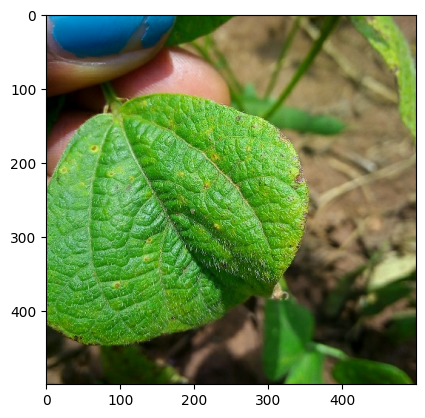

Actual Label : bean_rust
Predicted Label : bean_rust


In [20]:
for test_sample in datasets[1].take(10):
    image, label = test_sample[0], test_sample[1]
    image_scaled, label_arr = scale(test_sample[0], test_sample[1])
    image_scaled = np.expand_dims(image_scaled, axis = 0)

    img = tf.keras.preprocessing.image.img_to_array(image)

    pred = model.predict(image_scaled)

    print(pred)

    plt.figure()
    plt.imshow(image)
    plt.show()

    print("Actual Label : %s" %info.features['label'].names[label.numpy()])
    print("Predicted Label : %s" %info.features['label'].names[np.argmax(pred)])


In [21]:
for f0, f1 in datasets[1].map(scale).batch(200):
    y = np.argmax(f1, axis = 1)
    y_pred = np.argmax(model.predict(f0), axis = 1)

    print(tf.math.confusion_matrix(labels = y, predictions = y_pred, num_classes = 3))

4/4 [==============================] - 9s 2s/step
tf.Tensor(
[[40  3  0]
 [ 7 34  2]
 [ 0  4 38]], shape=(3, 3), dtype=int32)
